<a href="https://colab.research.google.com/github/beatrice-bu/Heart_Data_Modelling/blob/main/Heart_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 
import numpy as npss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Heart Data Modelling - Predicting The Probability of a Fatal Heart Failure

Data can be found at https://www.kaggle.com/rude009/heart-failure-model-prediction-comparisons-95

I will perform a brief exploratory data analysis followed by modelling, hyperparameter optimization and model evaluation in ~6.5 hours.

We will create a model, trained on 300 records of heart patient which will learn to predict if a patient has a greater than 50% chance of having a heart failure with ~80% accuracy.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/heart_failure_clinical_records_dataset.csv')
#loading in data

First, I load in the data with Pandas' read_csv method. I name the data `df` for DataFrame

In [ ]:
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


Here we can see a truncated view of the dataframe, we have 13 features:

- `Age`: Age of the patient, in years. Continuous value.
- `anaemia`: Decrease of red blood cells or hemoglobin. Discrete binary value.
- `creatinine_phosphokinase`: Levels of CPK enzyme in the blood (mcg/L). Continuous value.
- `diabetes`: If the patient has diabetes. Discrete binary value.
- `ejection_fraction`: Percentage of blood leaving the heart at each contraction (percentage). Continuous value.
- `high_blood_pressure`: If the patient has hypertension. Discrete binary value.
- `platelets`: Platelets in the blood (kiloplatelets/mL). Continuous value.
- `serum_creatinine`: Level of serum creatinine in the blood (mg/dL). Continuous value.
- `serum_sodium`: Level of serum sodium in the blood (mEq/L). Continuous value.
- `sex`: Woman or Man. Discrete binary value.
- `smoking`: If the patient smokes. Discrete binary value.
- `time`: Days since last follow-up (days). Continuous value.
- `DEATH_EVENT`: If the patient deceased during the follow_up period. Discrete binary value.

Our independent, target variable to determine if someone has had a heart failure will be `DEATH_EVENT`. We need to build a model that will accurately predict `DEATH_EVENT` of a patient based on the rest(dependent) variables.

In [ ]:
df.info()
#Dataframe method to view data info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


After taking a look at `.info`, we can see there are 299 observations, and every column is numerical. There are no null values.

In [ ]:
raw_describe = df.describe().T
#create a DataFrame of df's descriptive details. Transposed so that variables are the index.

display(raw_describe)

discrete_values = raw_describe[raw_describe['max']==1.0].index[:-1]
#Observing the numerically discrete binary values by finding all columns with a 'max' value of 1, excluding the target variable.
print(discrete_values)

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


Index(['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking'], dtype='object')


#### Observations:
- `creatinine_phosphokinase`, `platelets` and `serum_creatinine` seem to have obvious outliers as their `mean` value is a fraction of the size of their `max` value.
- Of these, `creatinine_phosphokinase` and `platelets` have high `std (Standard Deviation)`. This informs me that a `Standard Scaler` will probably perform best to level out the variance of the data. Alternatively, to combat the occurence of outliers in the formly mentioned variables, a `Robust Scaler` may work better.

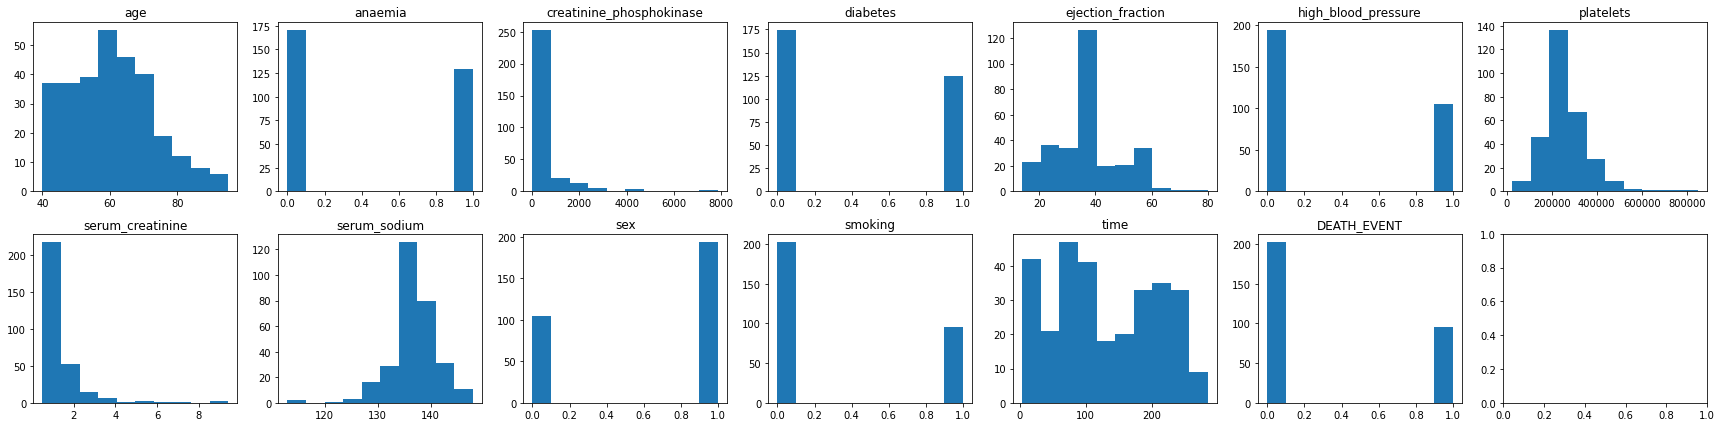

In [ ]:
fig, axs = plt.subplots(2,7, figsize =(30,7))
#instantiate a figure and axises for several subplots within. There are 13 values so I do 2 * 7 slots.
fig.subplots_adjust(hspace = .25, wspace = .20)
#adjusting the subplots to be more readible and separate from eachother
axs = axs.ravel()
#axs is an array of values for each subplot. np.ravel() flattens to a 1 dimensional array to be fed to our for loop
for idx, column in enumerate(df.columns):
    #getting the index for every column
    axs[idx].set_title(column)
    axs[idx].hist(df[column])
    #because we've flattened the axs array, we can just slice by the index
    

#### Visual Observations:
- Visually we can confirm that `creatinine_phosphokinase` and `serum_creatinine` are heavily biased, with outliers among large values. A potential space for data preprocessing would be to transform these with a `log_transform` to even out their variance.
- We can see that `DEATH_EVENT` has a class imbalance, with more people not dying than dying. This may require `stratifying` when building a model to have equal occurences of Death/Not Death so that our model is not biased.


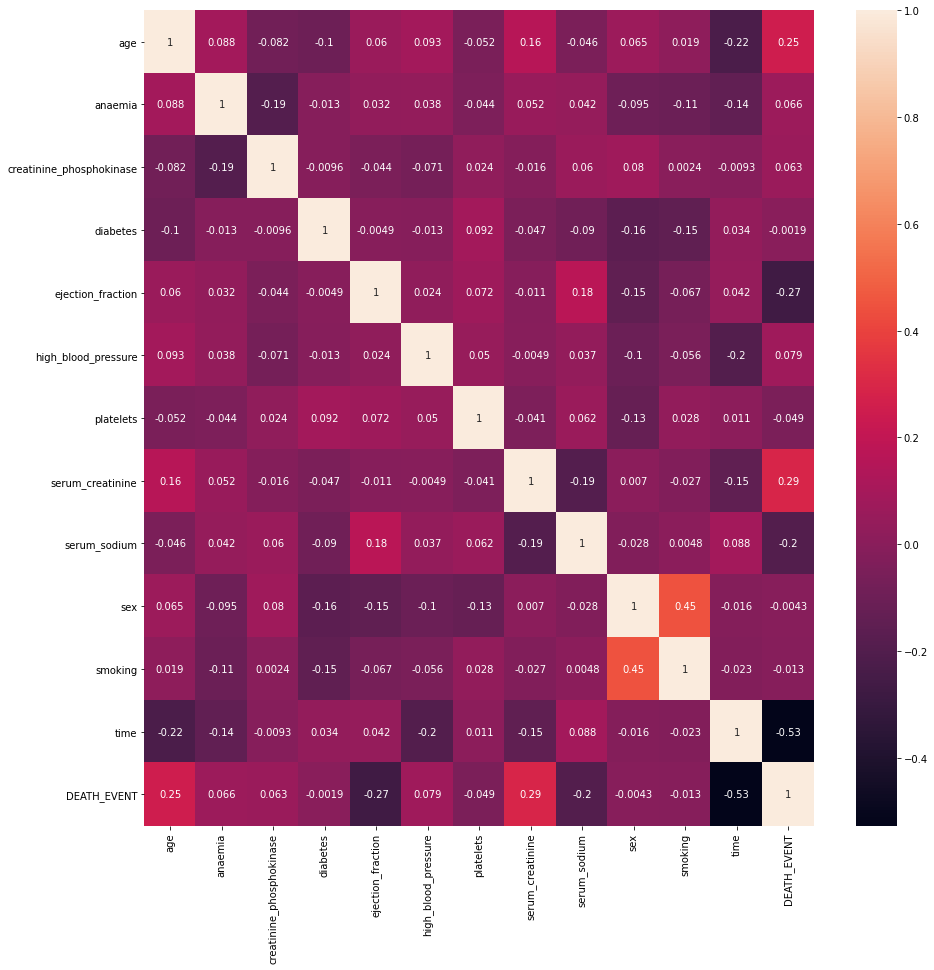

In [ ]:
corr_matrix = df.corr()
#.corr() is a method of the DataFrame class that returns an array of correlations between every variable
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True)
#sns.heatmap takes that .corr() output and returns a heatmap plot
plt.show()

#### Correlation Observations
We want to visually check the correlations of our dependent variables to make sure none of them are strongly correlated with eachother. This can introduce `multicolinearity` into our model which makes it less robust and more fragile to small changes in the data. For this purpose, we will consider anything over `.60` correlation a significant relationship.
- We can confirm however that other than a small relationship with `sex` and `smoking`, we do not have to worry about `multicolinearity`.

In [ ]:
X = df.drop('DEATH_EVENT', axis=1)
# dropping death event to isolate dependent variables
y = df['DEATH_EVENT']
# isolating target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, shuffle=True)
#Making a train and test version of both X and y. Test is 15% of the full dataset, data is shuffled to possible remove ordinal bias.

Now that we understand our data better, we can begin to preprocess it for modelling. We first separate the `X` (dependent variables) from the `y` (target variable: `DEATH_EVENT`). We then split our data into `train` splits for optimizing our model, and a `test` split for final evaluation that acts as unseen, real world data.

In [ ]:
display(X_train)
display(y_train)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
272,67.0,0,213,0,38,0,215000.00,1.2,133,0,0,245
37,82.0,1,855,1,50,1,321000.00,1.0,145,0,0,30
165,80.0,0,776,1,38,1,192000.00,1.3,135,0,0,130
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271
138,62.0,0,281,1,35,0,221000.00,1.0,136,0,0,108
...,...,...,...,...,...,...,...,...,...,...,...,...
270,44.0,0,582,1,30,1,263358.03,1.6,130,1,1,244
222,42.0,1,86,0,35,0,365000.00,1.1,139,1,1,201
44,60.0,1,588,1,60,0,194000.00,1.1,142,0,0,33
139,50.0,0,1548,0,30,1,211000.00,0.8,138,1,0,108


272    0
37     1
165    1
295    0
138    0
      ..
270    0
222    0
44     1
139    0
117    0
Name: DEATH_EVENT, Length: 254, dtype: int64

A view of what our `X` and `y` look like separated.

#### Model-building and Hyper-parameter Optimization

To find the best performing model, we will need to instantiate model classes, and find the best combination of parameters that work for this specific data. Each model has different parameters that alter the function and efficacy. To cast a wide net and get an easy idea for a well performing combination, we will automate the process with a `Pipeline` and `GridSearch`. This will perform every combination of data-scale type, classifier algorithm and algorithm parameters. We will use `Cross Validation` to evaluate the data on 3 separate validation splits of itself. This allows up to train, optimize and get an idea of a score for this model without touching the test data, which should be left entirely alone until the model is finished.


The difficulty and risk will be choosing a wide enough range of possible values while still choosing a gridsearch that will execute in a timely manner.

In [ ]:
#build a pipeline object to pair scalers and models together without needing to manually scale
model_pipeline = Pipeline( [
    #the parameters given simply act as placeholders
    ('scaling', StandardScaler()),
    ('model', SVC())
                ]
)

hyperParameterOptimization_Grid = [
    {
        #Support Vector Classifier
        
        'scaling': [StandardScaler()],
        
        'model': [SVC()],
        #instantiate specified model.
        
        # Example of hpyerparameter optimization
     
        'model__kernel': ['linear'],
        #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
        'model__C': np.linspace(0.0001, 10, 5),
        #Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. 
        
    },
    {
        #AdaBoost
        'scaling': [StandardScaler(), RobustScaler()],
        #scores based on standard scaled data, robust scaled data 
        'model': [AdaBoostClassifier()],
        'model__n_estimators': range(5, 40, 5),
        'model__learning_rate': np.linspace(.0001, .5, 5)
        
    },
    
    {
        #GradientBoost
        'scaling': [StandardScaler(), RobustScaler()],
        'model': [GradientBoostingClassifier()],
        'model__n_estimators': range(100, 200, 20),
        'model__learning_rate': np.linspace(.0001, .5, 5)
        
    }
]

gridsearch = GridSearchCV( #instantiate gridsearch object
    estimator = model_pipeline,
    #the first argument asks for a pipeline
    param_grid = hyperParameterOptimization_Grid,
    #second arguement asks for the parameter grid
    cv = 3,
    #how many splits should the data test on itself? Could be much higher but would increase computation by hours
    scoring= "accuracy",
    #specifying we want a model that performs most accurately
    verbose=5,
    n_jobs= -1)
    #specifying the number of jobs run in parallel. namely all of them

gridsearch.fit(X_train, y_train)
#fitting the new grid object to our training data

Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:   16.3s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaling',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol...

In [ ]:
gridsearch.best_estimator_
#attribute that returns the best combination based on accuracy

Pipeline(memory=None,
         steps=[('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=0.125075, n_estimators=20,
                                    random_state=None))],
         verbose=False)

## A brief look at further optimization: Visualizing Gradients

In [ ]:
s_scale = StandardScaler()
#instantiating a standard scaler
s_scale.fit(X_train)
#fit the scaler to the training data
X_train_scaled = s_scale.transform(X_train)
#transform training data to be scaled
X_test_scaled = s_scale.transform(X_test)
#once training data is scaled, transform test data
ada = AdaBoostClassifier(learning_rate=0.125075, n_estimators=20)
#instantiate our best model with the apparent best params
cv_score = cross_val_score(ada, X_train_scaled, y_train, cv=5)
#score the model on 5 seperate cross sections of the data to see robustness
print(cv_score)
for i in range(len(cv_score)):
    print(f"Fold {i+1}: {cv_score[i]}")
print(f"Average Score:{np.mean(cv_score)}")



[0.80392157 0.88235294 0.78431373 0.88235294 0.82      ]
Fold 1: 0.803921568627451
Fold 2: 0.8823529411764706
Fold 3: 0.7843137254901961
Fold 4: 0.8823529411764706
Fold 5: 0.82
Average Score:0.8345882352941176


After reproducing the best estimator of our gridsearch, we get a cross_validated score of 83.45%, which is not bad.

#### Scree Plot Optimization

To tune in further to find the best possible score, we will run over a range of possible scores deeper than a grid-search for specific parameters and visualize the efficacy.

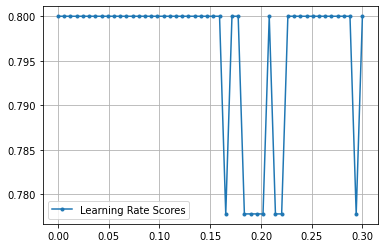

In [ ]:
learning_rates = np.linspace(.00001, .3, 50)
#instantiate linear space of 50 evenly placed values from 0.00001 to .3
scores = []

for rate in learning_rates:
  #for every parameter, run the model again with that parameter
    potential_model = AdaBoostClassifier(learning_rate=rate, n_estimators=20).fit(X_train_scaled, y_train)
    #score the model and add it to the score list
    scores.append(
        potential_model.score(X_test_scaled, y_test)
    )
plt.figure()
#plot the learning rates against the scores
plt.plot(learning_rates, scores, label="Learning Rate Scores", marker=".")
plt.legend()
plt.grid()
plt.show()

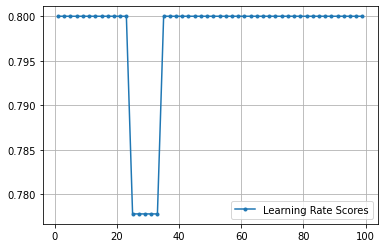

In [ ]:
estimators = np.arange(1 ,101, 2)
# essentially the same but for `n_estimators`
scores = []

for estimator in estimators:
    potential_model = AdaBoostClassifier(learning_rate=0.15, n_estimators=estimator).fit(X_train_scaled, y_train)
    scores.append(
        potential_model.score(X_test_scaled, y_test)
    )
plt.figure()
plt.plot(estimators, scores, label="Learning Rate Scores", marker=".")
plt.legend()
plt.grid()
plt.show()

We can confirm we've reached at the very least the global minima, and have reached a plateau for performance for this model. As previously mentioned, stratifying the data to balance the classes may improve performance, that will be the last optimizing we do. We will save our final predictions as `y_pred`. 


`y_pred` Will be created with the `.predict()` method which scores each observation as 0 if the probability of heart failure is less than 50%, and a 1 if the probability of heart failure is 50% or greater.

In [ ]:
s_scale = StandardScaler()
s_scale.fit(X)
X_scale = s_scale.transform(X)

X_train_strat, X_test_strat, y_train, y_test = train_test_split(X_scale, y, stratify=y)
#Creating a stratified version of the dataset that is class-balanced to remove bias.

In [ ]:
potential_Best_model = AdaBoostClassifier(learning_rate=0.15, n_estimators=22).fit(X_train_strat, y_train)

best_gridsearch_score = potential_Best_model.score(X_test_strat, y_test)
print(best_gridsearch_score)
cv_score = cross_val_score(ada, X_scaled, y, cv=5)
print(cv_score)
for i in range(len(cv_score)):
    print(f"Fold {i+1}: {cv_score[i]}")
print(f"Average Score:{np.mean(cv_score)}")

y_pred = potential_Best_model.predict(X_test_strat)

0.8666666666666667
[0.48333333 0.8        0.85       0.7        0.6779661 ]
Fold 1: 0.48333333333333334
Fold 2: 0.8
Fold 3: 0.85
Fold 4: 0.7
Fold 5: 0.6779661016949152
Average Score:0.7022598870056497


Our model's final score comes out to 86.66% accuracy, with an average cross valued score of 70%. This might mean our model is slightly less robust and overfit to our data, but overall performs very well. The low cross validation score may be related to the fact that these are tiny splits to an already tiny dataset, and there may not be enough variance to train the model well.

### xGradient Boosting

Finally, we will lastly compare our previous best model to a grid-searched XGradientBoosted model. My personal favourite algorithm, a go-to model and very often the most effective. It will run through every combination of parameters for XGBoost, and score itself on 3 splits.

In [ ]:

xgb_params = {
    'n_estimators': [1000],
    'max_depth': range(3,6),
    'min_child_weight': range(1, 11, 3),
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'gamma': np.linspace(0.5, 5, 3)
}

xgBoost = XGBClassifier(objective='binary:logistic')
xgb_grid = GridSearchCV(estimator=xgBoost, param_grid=xgb_params, n_jobs = -1, cv = 3, verbose=5)

xgb_grid.fit(X_train_strat, y_train, eval_set=[(X_test_strat, y_test)])

xgb_grid.best_estimator_

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  9.1min


[0]	validation_0-error:0.333333
[1]	validation_0-error:0.173333
[2]	validation_0-error:0.333333
[3]	validation_0-error:0.24
[4]	validation_0-error:0.2
[5]	validation_0-error:0.2
[6]	validation_0-error:0.2
[7]	validation_0-error:0.2
[8]	validation_0-error:0.2
[9]	validation_0-error:0.186667
[10]	validation_0-error:0.2
[11]	validation_0-error:0.2
[12]	validation_0-error:0.2
[13]	validation_0-error:0.213333
[14]	validation_0-error:0.213333
[15]	validation_0-error:0.213333
[16]	validation_0-error:0.213333
[17]	validation_0-error:0.2
[18]	validation_0-error:0.213333
[19]	validation_0-error:0.213333
[20]	validation_0-error:0.213333
[21]	validation_0-error:0.213333
[22]	validation_0-error:0.173333
[23]	validation_0-error:0.173333
[24]	validation_0-error:0.173333
[25]	validation_0-error:0.2
[26]	validation_0-error:0.173333
[27]	validation_0-error:0.173333
[28]	validation_0-error:0.173333
[29]	validation_0-error:0.173333
[30]	validation_0-error:0.173333
[31]	validation_0-error:0.173333
[32]	val

[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 10.0min finished


[70]	validation_0-error:0.186667
[71]	validation_0-error:0.186667
[72]	validation_0-error:0.186667
[73]	validation_0-error:0.186667
[74]	validation_0-error:0.173333
[75]	validation_0-error:0.173333
[76]	validation_0-error:0.173333
[77]	validation_0-error:0.173333
[78]	validation_0-error:0.173333
[79]	validation_0-error:0.173333
[80]	validation_0-error:0.173333
[81]	validation_0-error:0.173333
[82]	validation_0-error:0.173333
[83]	validation_0-error:0.173333
[84]	validation_0-error:0.173333
[85]	validation_0-error:0.186667
[86]	validation_0-error:0.186667
[87]	validation_0-error:0.186667
[88]	validation_0-error:0.186667
[89]	validation_0-error:0.186667
[90]	validation_0-error:0.186667
[91]	validation_0-error:0.186667
[92]	validation_0-error:0.186667
[93]	validation_0-error:0.2
[94]	validation_0-error:0.2
[95]	validation_0-error:0.2
[96]	validation_0-error:0.2
[97]	validation_0-error:0.2
[98]	validation_0-error:0.2
[99]	validation_0-error:0.186667
[100]	validation_0-error:0.186667
[101]	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=5.0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

In [ ]:
best_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=5.0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1).fit(X_train_strat, y_train)

final_score = best_xgb.score(X_test_strat, y_test)

print(final_score)

0.8133333333333334


After taking the `best_estimator_` from our gridsearch, our XGBoost seems to have a lower overall accuracy than our AdaBoost model. We will continue with our original grid-searched AdaBoost and evaluate it further.

##Model Evaluation
To evaluate the model, we will also assess it's `Precision`, `Recall` and `F-score` by comparing `y_test` to `y_pred`.

Terms:
- tp: True Positive. Number of fatal deaths predicted correctly
- fp: False Positive. Number of non-fatal deaths predictly as fatal.
- tn: True Negative. The number of negative cases correctly predicted as negative.
- fn: The number of false negatives inccorectly predicted to be non-fatal, but actually were.

From the Sklearn Documentation:


"The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0"

Recall: 0.8247549019607843, Precision: 0.8613636363636363, F-1 Score: 0.8391938250428816


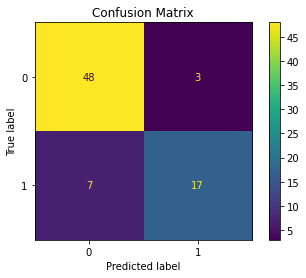

In [ ]:
rc = recall_score(y_test, y_pred,average='macro')
pr = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Recall: {rc}, Precision: {pr}, F-1 Score: {f1}')

cf_matrix = confusion_matrix(y_test, y_pred)
#instantiate matrix
ConfusionMatrixDisplay(cf_matrix, display_labels=potential_Best_model.classes_).plot()
#plotting confusion matrix
plt.title('Confusion Matrix')
plt.show()

## Conclusion

We have created a machine learning model trained on 300 records of heart patients to predict(based on a range of health indicators) how likely a person is to have a heart failure.

Our final model tested on 65 final records.
- Our model predicted 17 correct heart failures, out of 20 and thus falsely predicted 3 living records as heart failures.
- Our model correctly predicted 48 living records out of 55 total records, falsely classifying 7 living records as dead.

This leaves us with a Recall of `82.47%`, Precision of `86.13%` and a harmonized final F-1 Score of `83.91%`.